Following https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118

Imports

In [81]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from Discriminator import Discriminator

Set device to GPU (cuda) if available

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Download mnist dataset

In [67]:
train_dataset = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = False,
)
test_dataset = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

10000

Print some datapoints using matplotlib

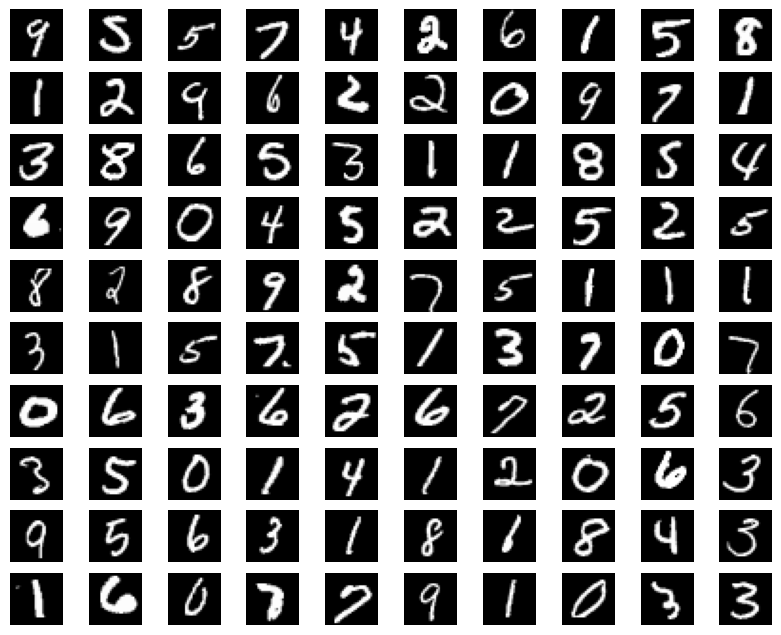

In [69]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 10, 10
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Set hyperparameter and load datasets into pytorch DataLoader. This allows to batch data and shuffle after each epoch. It also allows using multiple processors and load data directly into CUDA tensors.

In [70]:
num_workers = 5
batch_size = 100
num_classes = 10
learning_rate = 0.001
num_epochs = 5
num_channels = 1
size_z = 100
adam_beta1 = 0.5
num_gpu = 0

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Weight initialization from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html:

"From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization."

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Load Discriminator (CNN) class

In [82]:
discriminator = Discriminator().to(device)

loss function and optimization function

In [83]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

Training function

In [84]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = discriminator(images)
        loss = criterion(outputs, labels)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

START TRAINING
Epoch [1/5], Step [100/600], Loss: 0.0998
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/yashar/.conda/envs/thesis/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_46067/634376879.py", line 15, in <module>
    optimizer.step()
  File "/home/yashar/.conda/envs/thesis/lib/python3.10/site-packages/torch/optim/optimizer.py", line 139, in wrapper
    if id(p) not in param_mappings})
  File "/home/yashar/.conda/envs/thesis/lib/python3.10/site-packages/torch/autograd/profiler.py", line 488, in __enter__
  File "/home/yashar/.conda/envs/thesis/lib/python3.10/site-packages/torch/_ops.py", line 442, in __call__
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/yashar/.conda/envs/thesis/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/h

In [74]:
discriminator.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = discriminator(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Model Accuracy on the 10000 test images: {} %'.format(100 * correct / total))


Model Accuracy on the 10000 test images: 98.78 %


In [76]:
torch.save(discriminator.state_dict(), 'model.ckpt')